В этой тетрадке я проверю оптимизацию постепенно — сначала просто попробую оптимизировать MSE с помощью градиентного спуска, а уже потом добавлю Optimal Transport.

In [38]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [39]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from geomloss import SamplesLoss
from tqdm import tqdm

from utils import Synthetic
from differentiable_rendering.sigmoids_renderer.renderer import Renderer

In [40]:
def compute_pixel_coords(image):
    return np.argwhere(image)


def compute_pixel_density(image):
    pixel_density = image[np.nonzero(image)]
    pixel_density /= np.sum(pixel_density)
    return pixel_density


def shift_lines(lines, dx=0, dy=0):
    new_masses = []
    
    for mass in lines:
        mass = list(mass)
        
        mass[0] += dx
        mass[2] += dx
        
        mass[1] += dy
        mass[3] += dy
        
        new_masses.append(tuple(mass))
            
    return new_masses

In [41]:
def visualize(renderer, image, line_batch, render_label):
    render = renderer.render(line_batch)[0].detach().cpu().numpy()
    x, y = np.nonzero(render)
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gist_gray')
    plt.scatter(x, y, cmap='gist_gray', label=render_label, alpha=0.5)
    plt.legend()
    plt.show()

In [42]:
device = "cuda:0"

mse_loss = torch.nn.MSELoss(reduction='sum')
DEFAULT_RENDERER = Renderer((64, 64), linecaps='butt', device=device, dtype=torch.float32)

def optimize_line_batch_mse_only(line_batch, image, n_iters=100, lr=0.1):
    line_batch.requires_grad_(True)
    
    image = torch.from_numpy(image).to(device)
    
    for step in range(n_iters):
        vector_masses = renderer.render(line_batch)[0]
        loss = mse_loss(vector_masses, image.T)
        
        if line_batch.grad is not None:
            line_batch.grad.data.zero_()
        
        loss.backward()
        
        grad = line_batch.grad.data
        grad[:, :, 4] = 0.
        grad[:, :, 5] = 0.
        
        line_batch.data -= lr * grad
    
    return line_batch


def get_pixel_coords_and_density(image):
    pixel_coords = compute_pixel_coords(image)
    pixel_density = compute_pixel_density(image)
    
    torch_pixel_coords = torch.from_numpy(pixel_coords.astype(np.float32)).to(device)
    torch_pixel_density = torch.from_numpy(pixel_density.astype(np.float32)).to(device)
    
    return torch_pixel_coords, torch_pixel_density

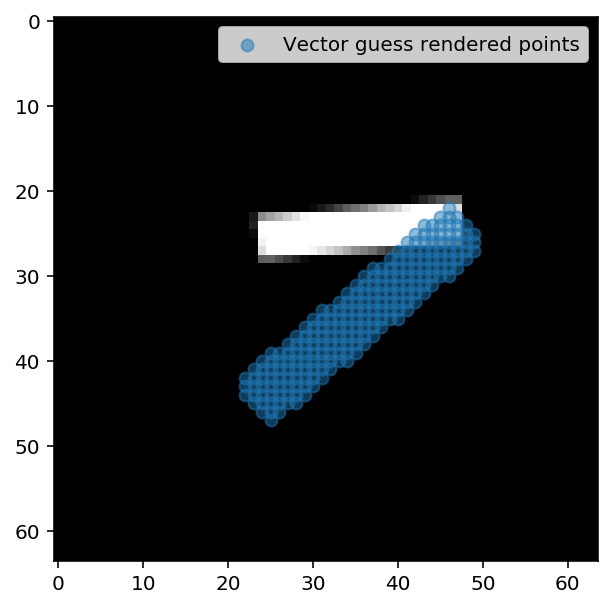

In [43]:
renderer = DEFAULT_RENDERER

generator = Synthetic(64, 64)
np.random.seed(111)
    
image, _ = generator.get_image('.', line_count=1)
image = 1 - np.array(image, dtype=np.float32) / 255

line_batch = np.array([[[45., 24., 25., 48., 5., 0.5]]]).astype(np.float32)
line_batch = torch.from_numpy(line_batch).to(device)
visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

In [44]:
line_batch = optimize_line_batch_mse_only(line_batch, image, n_iters=1000, lr=0.1)

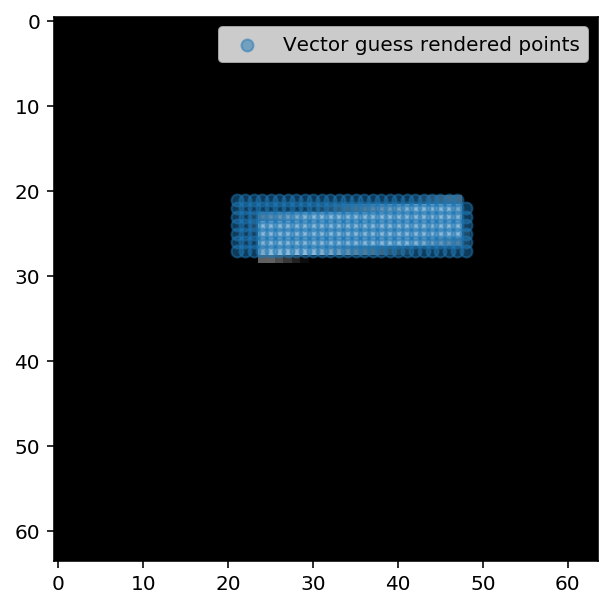

In [45]:
visualize(DEFAULT_RENDERER, image, line_batch, 'Vector guess rendered points')

In [17]:
line_batch

tensor([[[45.8778, 23.8081, 45.1409, 48.1034,  5.0000,  0.5000]]],
       device='cuda:0', requires_grad=True)

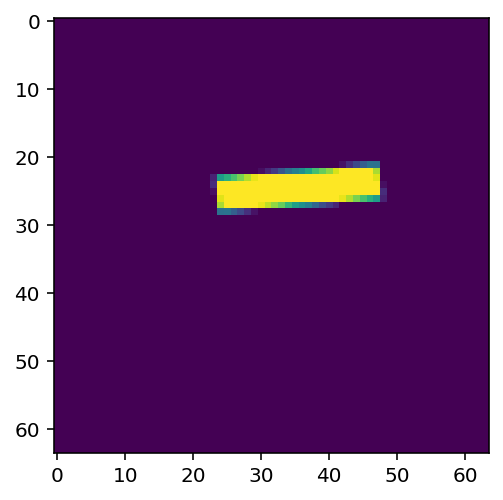

In [18]:
plt.imshow(image)